# КМ-01, Іваник Юрій, Лаб 3

### Імпортуємо бібліотеки

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Завантажимо датасет NSL-KDD

In [2]:
train_data = pd.read_csv('KDDTrain+.txt')
test_data = pd.read_csv('KDDTest+.txt')

### Даємо назви колонкам у датафреймі

In [3]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
            'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
            'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
            'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
            'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
            'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

train_data.columns = columns
test_data.columns = columns

### Об'єднюємо датасети -> Залишаємо лише `guess_passwd` та `normal` -> 75 % - навчання, 25 % тест

In [4]:
# Поєднання двох датафреймів
combined_data = pd.concat([train_data, test_data], axis=0)

# Розділення за типом атаки
attack_data = combined_data[combined_data['attack'] == 'guess_passwd']
normal_data = combined_data[combined_data['attack'] == 'normal']

# Розбиття на навчальний та тестовий набір
train_attack, test_attack = train_test_split(attack_data, test_size=0.25, random_state=42)
train_normal, test_normal = train_test_split(normal_data, test_size=0.25, random_state=42)

# Об'єднання навчальних та тестових наборів
train_data = pd.concat([train_attack, train_normal], axis=0)
test_data = pd.concat([test_attack, test_normal], axis=0)

# Виведення розмірів навчального та тестового наборів
print(f'Розмір навчального набору: {train_data.shape[0]}')
print(f'Розмір тестового набору:   {test_data.shape[0]}')

Розмір навчального набору: 58752
Розмір тестового набору:   19585


### Перевіримо кількість записів які містять тип атаки 'guess_passwd' або 'normal'

In [5]:
count_train_guess_pass = (train_data['attack'] == 'guess_passwd').sum()
count_test_guess_pass = (test_data['attack'] == 'guess_passwd').sum()
count_train_normal = (train_data['attack'] == 'normal').sum()
count_test_normal = (test_data['attack'] == 'normal').sum()

print(f"Кількість записів із 'guess_passwd' у навчальному наборі : {count_train_guess_pass}")
print(f"Кількість записів із 'guess_passwd' у тестовому наборі   : {count_test_guess_pass}")
print(f"Кількість записів із 'normal'       у навчальному наборі : {count_train_normal}")
print(f"Кількість записів із 'normal'       у тестовому наборі   : {count_test_normal}")

Кількість записів із 'guess_passwd' у навчальному наборі : 963
Кількість записів із 'guess_passwd' у тестовому наборі   : 321
Кількість записів із 'normal'       у навчальному наборі : 57789
Кількість записів із 'normal'       у тестовому наборі   : 19264


### Перекодуємо категорійні значення

In [6]:
# Використання one-hot encoding для категорійних змінних
filtered_train_data = pd.get_dummies(train_data, drop_first=True)
filtered_test_data  = pd.get_dummies(test_data,  drop_first=True)

### Перевіримо чи співпадають назви колонок та їх кількість
Це важливо оскільки ми передаємо ці значення в нейронну мережу

In [7]:
print(f'Колонок у \'filtered_train_data\': {filtered_train_data.shape[1]}')
print(f'Колонок у \'filtered_test_data\':  {filtered_test_data.shape[1]}')

# Отримання назв колонок для обох датафреймів
columns_train = set(filtered_train_data.columns)
columns_test = set(filtered_test_data.columns)

# Знаходження спільних назв колонок
common_columns = columns_train.intersection(columns_test)

# Виведення назв та кількості спільних колонок
print('Кількість спільних колонок:', len(common_columns))

# Знаходження унікальних колонок у кожному датафреймі
unique_columns_train = columns_train.difference(columns_test)
unique_columns_test = columns_test.difference(columns_train)

# Виведення назв унікальних колонок у кожному датафреймі
print(f'\nУнікальні колонки в filtered_train_data: \n{unique_columns_train}')
print(f'\nУнікальні колонки в filtered_test_data: \n{unique_columns_test}')

Колонок у 'filtered_train_data': 78
Колонок у 'filtered_test_data':  76
Кількість спільних колонок: 75

Унікальні колонки в filtered_train_data: 
{'flag_RSTOS0', 'flag_SH', 'service_link'}

Унікальні колонки в filtered_test_data: 
{'service_remote_job'}


### Подивимось наскільки багато цих даних і чи можемо ми їх позбутися

In [8]:
service_link = (train_data['service'] == 'link').sum()
flag_SH = (train_data['flag'] == 'SH').sum()
flag_RSTOS0 = (train_data['flag'] == 'RSTOS0').sum()

service_remote_job = (test_data['service'] == 'remote_job').sum()


print(f"Кількість записів із 'link'       у навчальному наборі: {service_link}")
print(f"Кількість записів із 'SH'         у навчальному наборі: {flag_SH}")
print(f"Кількість записів із 'RSTOS0'     у навчальному наборі: {flag_RSTOS0}")
print(f"Кількість записів із 'remote_job' у тестовому   наборі: {service_remote_job}")

Кількість записів із 'link'       у навчальному наборі: 1
Кількість записів із 'SH'         у навчальному наборі: 2
Кількість записів із 'RSTOS0'     у навчальному наборі: 1
Кількість записів із 'remote_job' у тестовому   наборі: 1


### Видаляємо дані
Тренувальний датасет містить більше 58 тис. даних, а тестовий датасет 19 тис.  
Тому видалення такої кількості даних не повинно сильно вплинути на результати досліджень 

In [9]:
train_data = train_data[(train_data['service'] != 'link') &
                        (train_data['flag'] != 'SH') &
                        (train_data['flag'] != 'RSTOS0')]

test_data = test_data[(test_data['service'] != 'remote_job')]

### Перевіримо чи зараз співпадають назви та кількість колонок

In [10]:
# Розділення 'attack' від інших змінних
attacks_train = train_data[['attack']]
attacks_test = test_data[['attack']]

# Видалення 'attack' з оригінального набору даних
train_data = train_data.drop(columns=['attack'])
test_data = test_data.drop(columns=['attack'])

# Перекодування за допомогою pd.get_dummies() для інших змінних
filtered_train_data = pd.get_dummies(train_data, drop_first=True)
filtered_test_data = pd.get_dummies(test_data,  drop_first=True)

# Додавання нового стовпця 'attack_guess_passwd'
filtered_train_data['attack_guess_passwd'] = attacks_train['attack'].map(lambda x: 1.0 if x == 'guess_passwd' else 0.0)
filtered_test_data['attack_guess_passwd'] = attacks_test['attack'].map(lambda x: 1.0 if x == 'guess_passwd' else 0.0)

In [11]:
print(f'Колонок у \'filtered_train_data\': {filtered_train_data.shape[1]}')
print(f'Колонок у \'filtered_test_data\':  {filtered_test_data.shape[1]}')

# Отримання назв колонок для обох датафреймів
columns_train = set(filtered_train_data.columns)
columns_test = set(filtered_test_data.columns)

# Знаходження спільних назв колонок
common_columns = columns_train.intersection(columns_test)

# Виведення назв та кількості спільних колонок
print(f'Кількість спільних колонок: \t {len(common_columns)}')

Колонок у 'filtered_train_data': 75
Колонок у 'filtered_test_data':  75
Кількість спільних колонок: 	 75


### Для коректної роботи НМ треба нормалізувати дані

In [12]:
scaler = MinMaxScaler()

new_columns = filtered_train_data.columns

filtered_train_data[new_columns] = scaler.fit_transform(filtered_train_data[new_columns])
filtered_test_data[new_columns] = scaler.transform(filtered_test_data[new_columns])

### Створюємо клас ймовірнісної нейронної мережі (PNN)

In [13]:
class PNN:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.mean_vectors = None
        self.sigma = None
        self.weights = None


    def train(self, X, y, sigma=1.0):
        self.mean_vectors = []
        self.sigma = sigma

        # Обчислюємо середні вектори для кожного класу
        for class_label in range(self.output_size):
            class_samples = X[y == class_label]
            mean_vector = np.mean(class_samples, axis=0)
            self.mean_vectors.append(mean_vector)

        self.mean_vectors = np.array(self.mean_vectors)

        # Обчислюємо ваги для кожного класу
        self.weights = np.ones(self.output_size) / self.output_size


    def predict(self, X):
        predictions = []

        for sample in X:
            probabilities = []

            # Розраховуємо ймовірності для кожного класу
            for class_label in range(self.output_size):
                mean_vector = self.mean_vectors[class_label]
                sample = sample.astype(float)
                activation = np.exp(-0.5 * np.sum((sample - mean_vector) ** 2) / (self.sigma ** 2))
                probability = activation * self.weights[class_label]
                probabilities.append(probability)

            # Визначаємо клас з найвищою ймовірністю
            predicted_class = np.argmax(probabilities)
            predictions.append(predicted_class)

        return np.array(predictions)

### Розділимо датафрейми `filtered_train_data` та `filtered_test_data` на X_train, X_test, y_train, y_test

In [14]:
X_train = filtered_train_data.drop(columns=['attack_guess_passwd'])
y_train = filtered_train_data['attack_guess_passwd']

X_test = filtered_test_data.drop(columns=['attack_guess_passwd'])
y_test = filtered_test_data['attack_guess_passwd']

### Ініціалізуємо модель PNN

In [15]:
input_size = train_data.shape[1]
output_size = 2  # розмірність вихідного шару (два класи: guess_passwd та normal)

pnn = PNN(input_size, output_size)

### Навчання PNN

In [16]:
pnn.train(X_train, y_train, sigma=1.0)

### Використання PNN

In [17]:
predictions = pnn.predict(X_test.values)

### Знайдемо метрики, щоб зрозуміти наскільки хороших результатів було досягнуто

In [18]:
y_true = y_test
accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions)
recall = recall_score(y_true, predictions)
f1 = f1_score(y_true, predictions)

print(f"Accuracy (Точність) : {round(accuracy * 100, 5)} %")
print(f"Precision (Точність): {round(precision * 100, 5)} %")
print(f"Recall (Повнота)    : {round(recall * 100, 5)} %")
print(f"F1 Score (F-міра)   : {round(f1 * 100, 5)} %")

Accuracy (Точність) : 93.55596 %
Precision (Точність): 20.27795 %
Recall (Повнота)    : 100.0 %
F1 Score (F-міра)   : 33.71849 %


### Побудуємо теплову карту з результатами дослідження

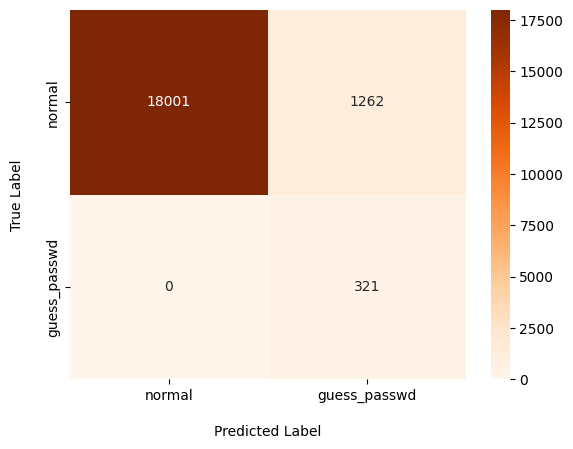

In [19]:
cm = confusion_matrix(y_true, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=['normal', 'guess_passwd'], yticklabels=['normal', 'guess_passwd'])
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()